### Modelling Spread of Diseases using Agent Based Modelling

In this project, the aim is to model the spread of diseases across individuals over time, accounting for the movement of individuals across a grid space. The set up is as follows:

Agent: Individual (location, infected, transmission rate, recovery rate, vacc status) The transmission rate dependent on vacc status and recovery rate is dependent on the strength of the disease, which factors their values up or down given strength, 
Potential other things to add: immunity after infection.

Disease (Strength) and also another factor of minimum recovery timestep, which is the minimum amount of time steps before any recovery (using the recovery rate) can be taken.

Environment: Consists of 10 different nodes/locations, where each node is has a 50x50 grid space, where agents can be at (agent.location)

Location Rules:

1. An agent can choose one of three choices, stay where they are, move to another grid space within the node, or move to another grid space at another node
2. Agents can move freely from one node to any other at one timestep, no hinderances besides capacity in 3.
3. If the grid space is already occupied by an agent, randomly select another space in the node, otherwise if all taken, randomly select another node and grid space.

Infection Rules:

1. An agent can be infected at a timestep if they are within a 5x5 grid space of an infected individual, dependent on their transmission rate.
2. The probability of the agent recovering from the infection depends on the recovery rate.
3. An individual that is infected has should not move from their location

Parameters to collect:

- Percentage of infected at each timestep for each node
- Percentage of infected by vacc status
- Average infections per population in node

Things to consider:
- Deaths (Death Rate Probability - Dependent on vaccs, and also immunity)
- Try one city first, if works then expand. 
- 3 parameters to determine movement of individual across grid space.

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import correlate2d

cmap = ListedColormap(['white', 'grey', 'red', 'blue'])
norm = BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

## Creating the Agent Class

In [383]:
#hyperparameters to tune
infection_rate = 0.1 # percentage of people infected
vacc_rate = 0.5 # percentage of people vaccinated
n_humans = 500
grid_space = 50
n_nodes = 10
steps = 100
scan_space = 5
movement_prob = [0.1, 0.5, 0.4]
min_infect_days = 2

In [384]:
class Human():
    def __init__(self):
        self.infected = np.random.random() < infection_rate
        self.transmission_rate = np.random.random()
        self.recovery_rate = np.random.random() < vacc_rate
        self.vaccine = np.random.random() < vacc_rate
        self.infected_time = 0

    '''Choose a new location to move to based on random probability'''
    def choose_newlocation(self):
        if self.infected: # stay at location
            self.decision = 0
        else: # make choice to move to a new location or stay
            # using a dirichlet distribution, which is distribution over vectors of probabilities that sum to 1
            random_moveto = np.random.dirichlet(np.ones(2), size=1)[0]
            self.decision = np.argmax(random_moveto)
        return self.decision

## Creating the Environment Grid Space of Suburb

This is just for one city, another class City (to contain 10 Suburbs)

In [391]:
class Suburb():
    # create a 50x50 grid space
    def __init__(self):
        self.grid = np.zeros((grid_space,grid_space))
        self.humans = []

    '''Populates the grid space with humans, initial configuration'''
    def populate(self, n_humans):
        # randomly place humans around in the grid, 1 person per grid space
        self.humans = [Human() for i in range(n_humans)]
        for human in self.humans:
            x = np.random.randint(0,grid_space)
            y = np.random.randint(0,grid_space)
            # check if the grid space is already occupied
            while self.grid[x,y] != 0:
                x = np.random.randint(0,grid_space)
                y = np.random.randint(0,grid_space)
            if human.infected:
                self.grid[x,y] = 2 # if infected
            else:
                self.grid[x,y] = 1 # if not infected
            human.location = (x,y) # save location of human
    
    '''checks the grid space around each human to find number of infected people''' 
    def scan(self, human):
        # find neighbours of human
        x, y = human.location[0], human.location[1]
        #neighbours = []
        # set boundary constraints
        x_min = max(0, x-scan_space)
        x_max = min(grid_space-1, x+scan_space)
        y_min = max(0, y-scan_space)
        y_max = min(grid_space-1, y+scan_space)
        neighbours = self.grid[x_min:x_max+1, y_min:y_max+1]
        infected = np.sum(neighbours == 2)
        if human.infected:
            return(infected - 1)
        else:
            return(infected)
            
        

In [392]:
sub = Suburb()
sub.populate(n_humans) # number of humans in the city cannot be greater than the number of grid spaces (50x50)

In [393]:
# test case of whether the new location is chosen well. 
for i in sub.humans[5:10]:
    print(i.infected, i.location)
    i.choose_newlocation()
    print(i.decision)


False (8, 41)
0
True (32, 36)
0
False (25, 16)
1
False (16, 46)
1
False (9, 20)
0


In [394]:
# randomly select 5 humans to test:
for i in range(5):
    human = sub.humans[np.random.randint(0, len(sub.humans))]
    print(human.location)
    print(sub.scan(human))

(34, 19)
3
(42, 21)
3
(37, 22)
4
(17, 24)
4
(42, 24)
1


(24, 15)
0


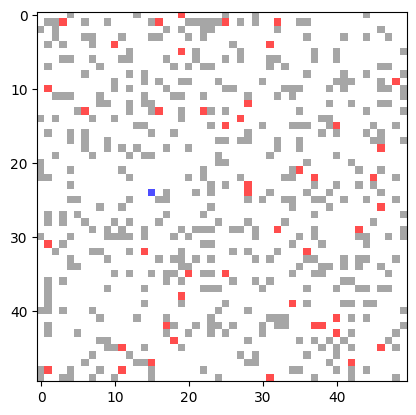

In [395]:
# check if the neighbours are being found correctly
def check_grid_infect():
    human = sub.humans[np.random.randint(0, len(sub.humans))]
    hx, hy = human.location[0], human.location[1]
    print(human.location)
    print(sub.scan(human))
    init = sub.grid[hx,hy] 
    sub.grid[hx,hy] = 4
    plt.imshow(sub.grid, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.7)
    plt.show()
    sub.grid[hx,hy] = init

check_grid_infect()

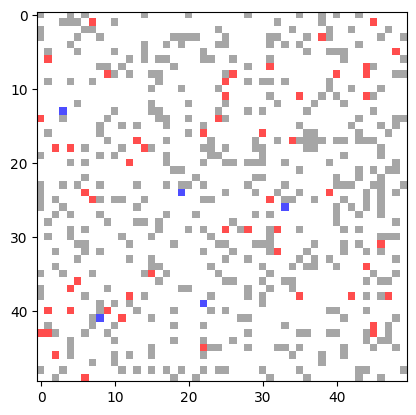

In [372]:

plt.imshow(sub.grid, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.7)
plt.show()

In [218]:
# check if the number of infected people is around 10% of the population
np.sum(v.grid == 2)/n_humans

0.094

In [227]:
grid = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

# Define a 5x5 window (kernel) for correlation
kernel = np.ones((scan_space, scan_space))

result = correlate2d(v.grid, kernel, mode='same', boundary='wrap')
result

array([[2., 2., 4., ..., 5., 4., 4.],
       [6., 5., 6., ..., 3., 5., 6.],
       [6., 5., 6., ..., 3., 4., 5.],
       ...,
       [4., 4., 5., ..., 5., 4., 5.],
       [3., 2., 4., ..., 5., 4., 4.],
       [2., 2., 4., ..., 5., 4., 4.]])